In [1]:
# import system libs
import os
import time
import pathlib
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2, l2, l1
from tensorflow.keras.optimizers import Adam, Adamax

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', 
                                       target_size= img_size, class_mode= 'categorical',
                                       color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', 
                                      target_size= img_size, class_mode= 'categorical',
                                      color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


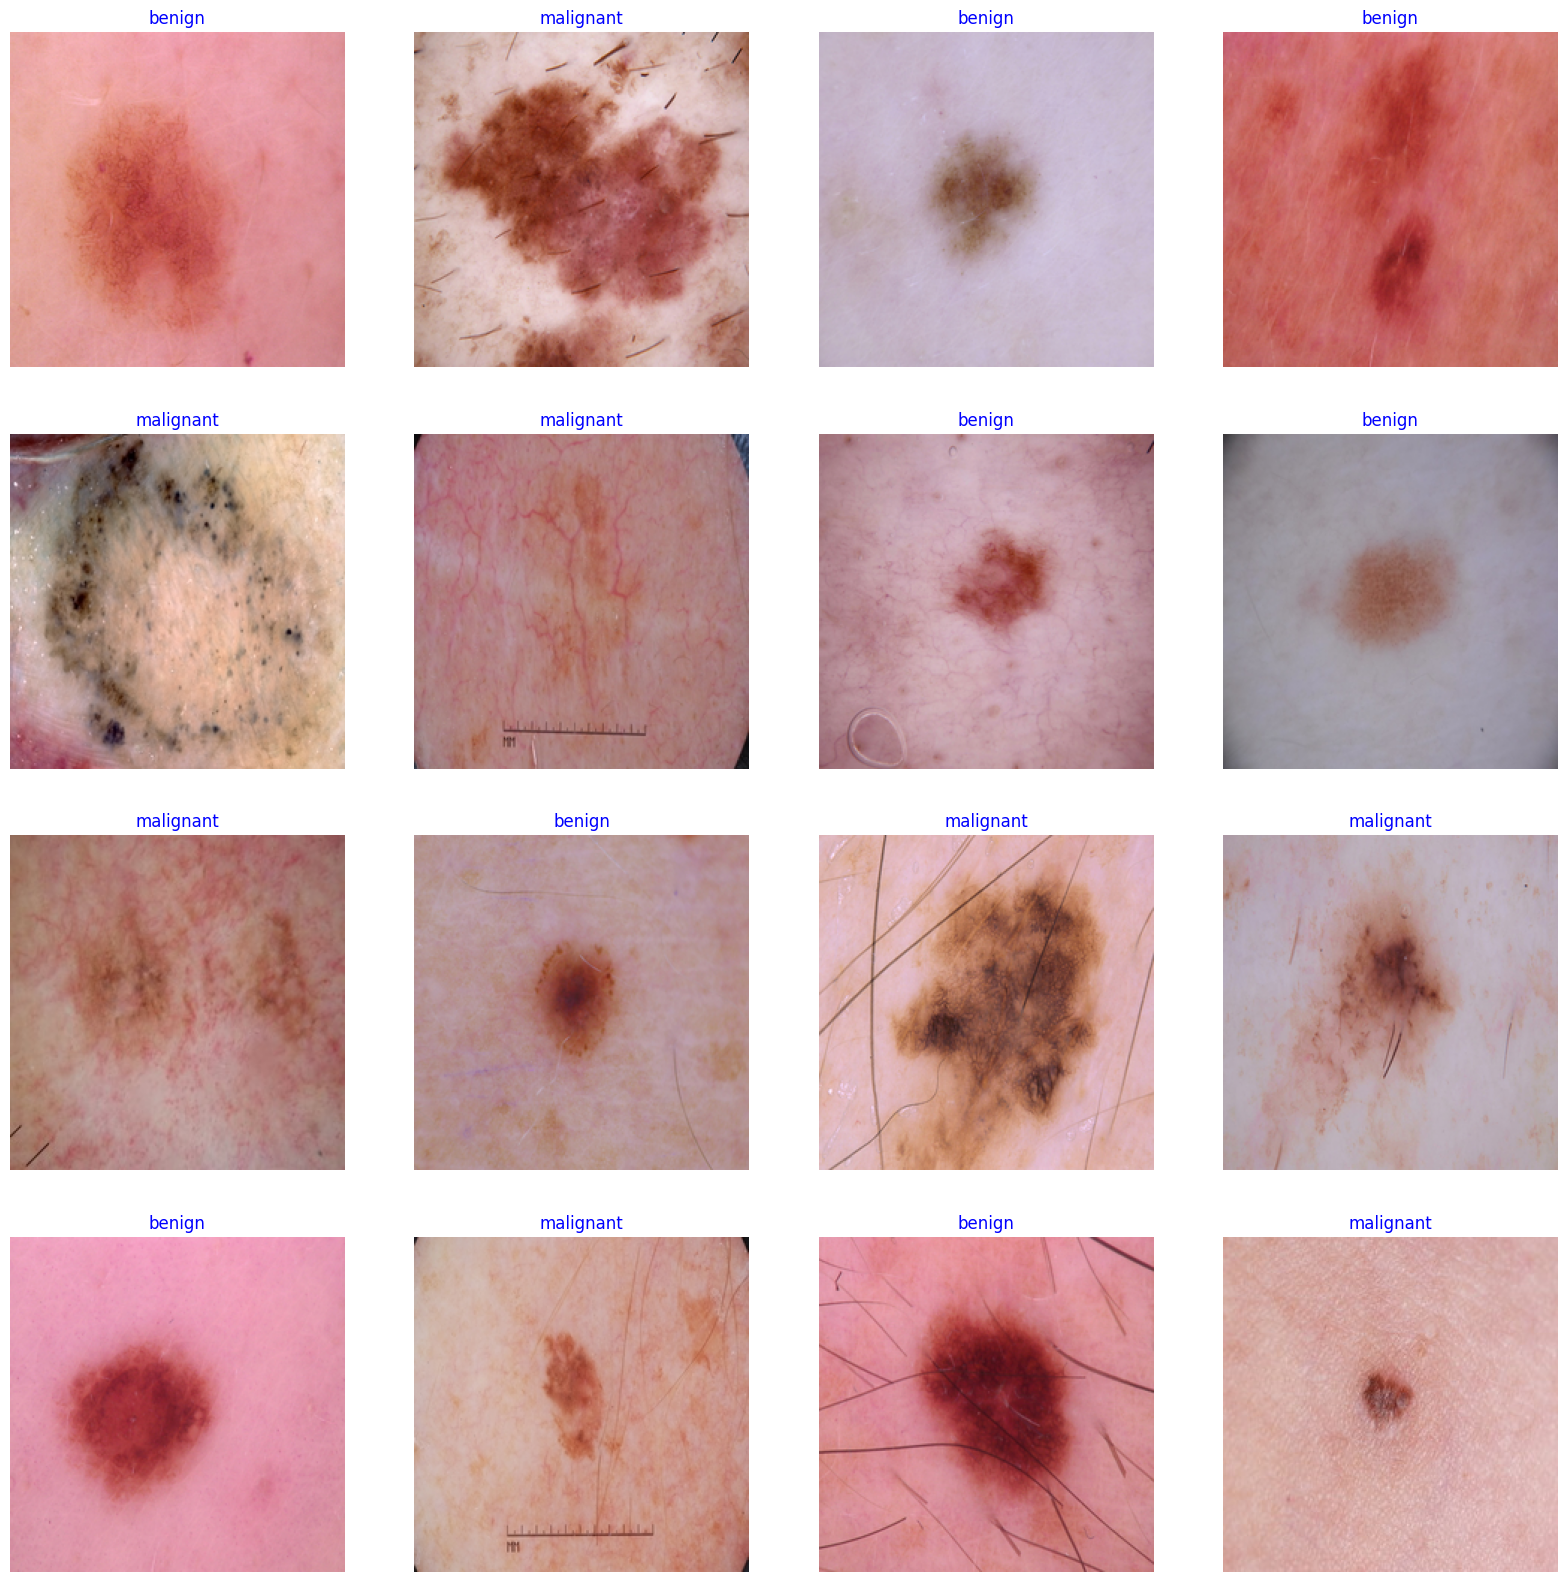

In [5]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255.
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

## My Model

In [ ]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu' ,input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
          
# Block 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
          
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
          
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
          
# Fully Connected layer 1
model.add(Flatten())
model.add(Dense(512,activation='relu', kernel_regularizer=l1_l2(0.01), activity_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
          
# Output layer
model.add(Dense(2,activation='sigmoid'))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_gen,
                     validation_data = test_gen,
                     batch_size = 64,
                     epochs = 30)

In [ ]:

# plots for accuracy and Loss with epochs

error = pd.DataFrame(history1.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [ ]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_gen)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(test_gen)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

In [ ]:
# prediction
result = model.predict(test_gen)

y_pred = np.argmax(result, axis = 1)

y_true = test_gen.labels

# Evaluvate
loss,acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

## Pretrained Model - EfficientNet

In [12]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                               input_shape= img_shape, pooling= 'max')

new_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, kernel_regularizer= l2(0.016), activity_regularizer= l1(0.026),
          bias_regularizer= l1(0.016), activation= 'relu'),
    Dropout(rate= 0.6),
    Dense(2, activation= 'sigmoid')
])

new_model.compile(optimizer=Adamax(),
                  loss= tf.keras.losses.BinaryCrossentropy(),
                  metrics= ['accuracy'])

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non-trainable params: 90,375
_____________________________________

In [13]:
history = new_model.fit(train_gen, epochs=20, validation_data=test_gen, shuffle=False)

Epoch 1/20


2024-01-24 09:08:24.449199: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


165/165 [==============================] - 100s 231ms/step - loss: 6.7533 - accuracy: 0.7937 - val_loss: 4.5699 - val_accuracy: 0.8242
Epoch 2/20
165/165 [==============================] - 35s 213ms/step - loss: 3.6751 - accuracy: 0.8294 - val_loss: 2.9203 - val_accuracy: 0.8606
Epoch 3/20
165/165 [==============================] - 35s 213ms/step - loss: 2.3982 - accuracy: 0.8506 - val_loss: 1.9276 - val_accuracy: 0.8803
Epoch 4/20
165/165 [==============================] - 35s 213ms/step - loss: 1.6449 - accuracy: 0.8745 - val_loss: 1.3476 - val_accuracy: 0.8894
Epoch 5/20
165/165 [==============================] - 35s 213ms/step - loss: 1.1780 - accuracy: 0.8934 - val_loss: 0.9988 - val_accuracy: 0.9030
Epoch 6/20
165/165 [==============================] - 35s 215ms/step - loss: 0.9088 - accuracy: 0.8915 - val_loss: 0.7880 - val_accuracy: 0.8924
Epoch 7/20
165/165 [==============================] - 35s 213ms/step - loss: 0.7359 - accuracy: 0.9075 - val_loss: 0.6708 - val_accuracy: 0.

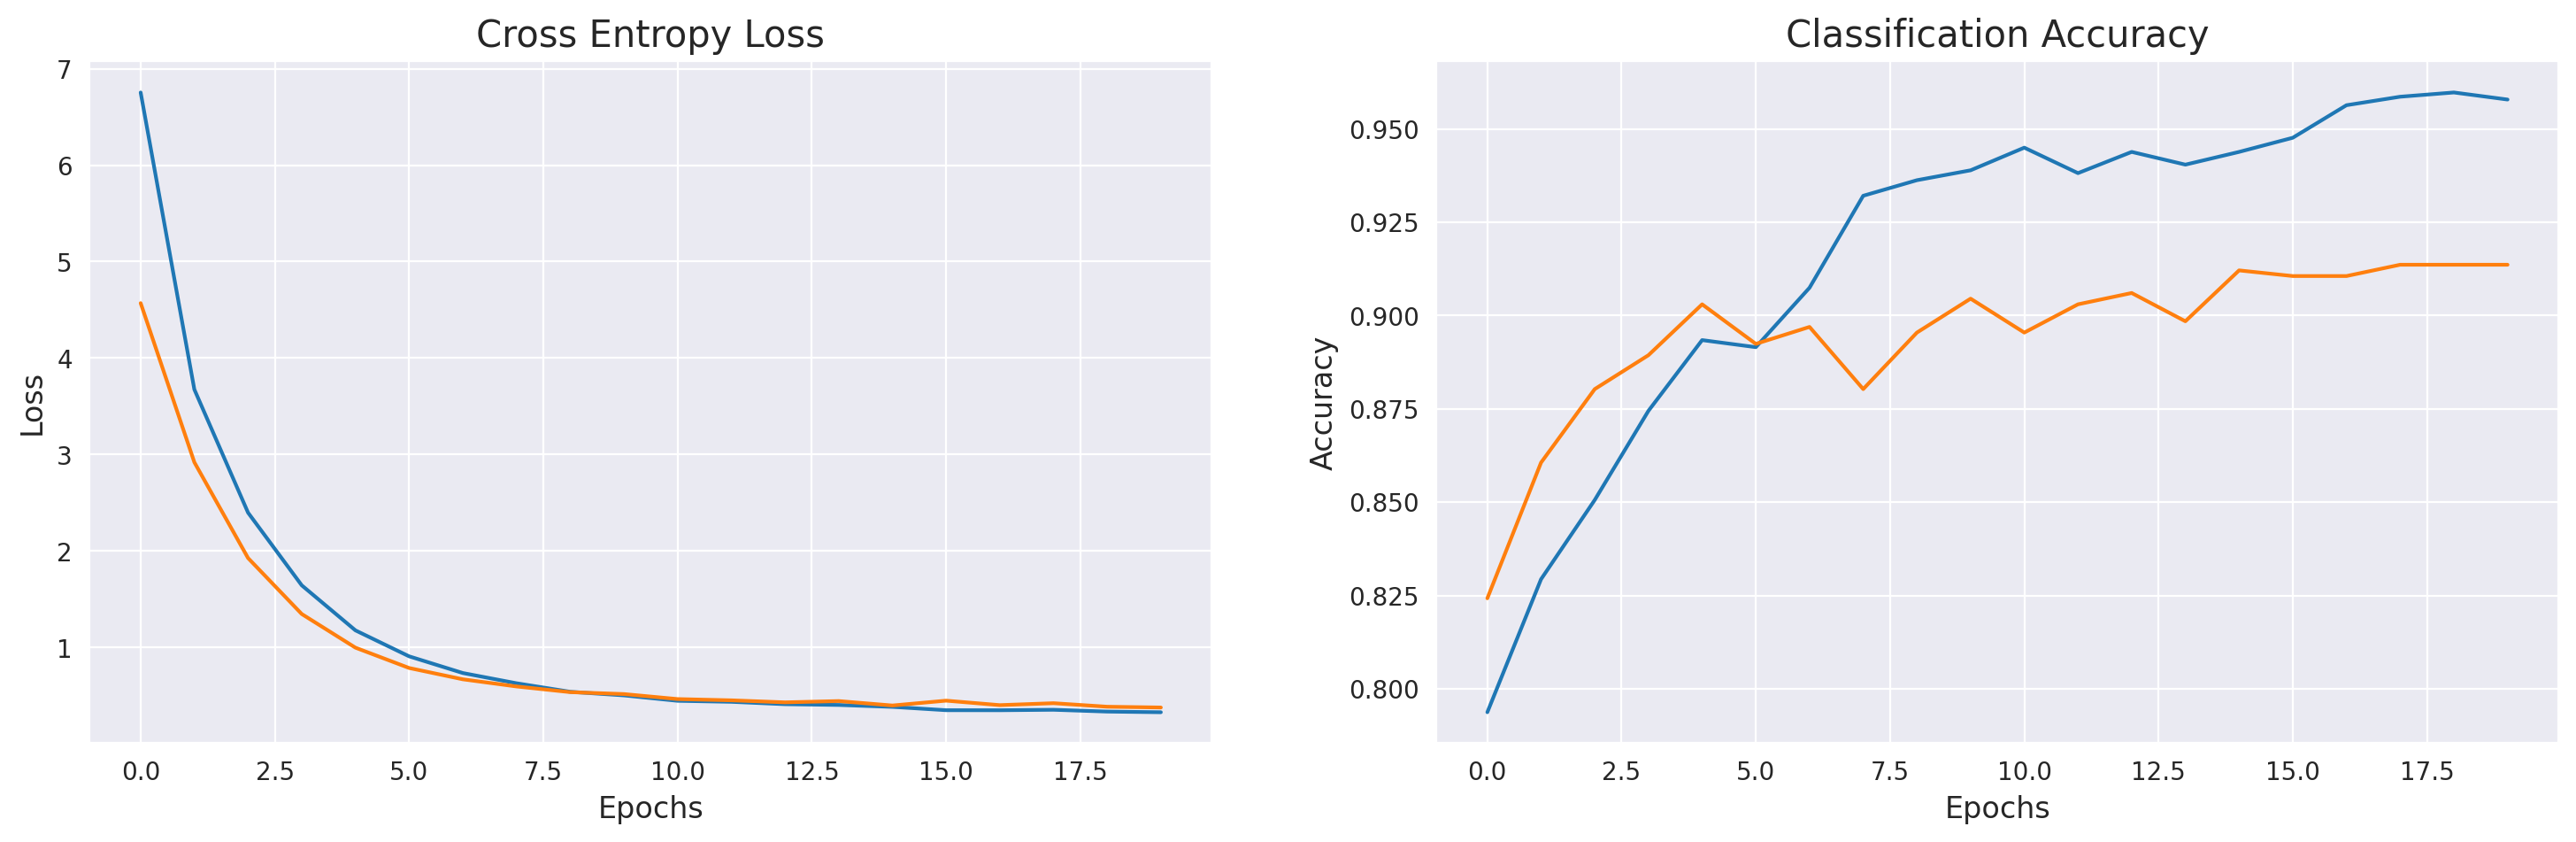

In [14]:

# plots for accuracy and Loss with epochs

error = pd.DataFrame(history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [16]:
# Evaluvate for train generator
loss,acc = new_model.evaluate(train_gen)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = new_model.evaluate(test_gen)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

165/165 [==============================] - 7s 43ms/step - loss: 0.2190 - accuracy: 0.9996
The accuracy of the model for training data is: 99.9620795249939
The Loss of the model for training data is: 0.21897463500499725
42/42 [==============================] - 2s 42ms/step - loss: 0.3785 - accuracy: 0.9136
The accuracy of the model for validation data is: 91.36363863945007
The Loss of the model for validation data is: 0.3784630298614502


In [17]:
# prediction
result = new_model.predict(test_gen)

y_pred = np.argmax(result, axis = 1)

y_true = test_gen.labels

# Evaluvate
loss,acc = new_model.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

42/42 [==============================] - 2s 43ms/step - loss: 0.3785 - accuracy: 0.9136
The accuracy of the model for testing data is: 91.36363863945007
The Loss of the model for testing data is: 0.3784630298614502


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       360
           1       0.89      0.92      0.91       300

    accuracy                           0.91       660
   macro avg       0.91      0.91      0.91       660
weighted avg       0.91      0.91      0.91       660

